In [1]:
import warnings
from src.utils_functions import *
from src.features import *

# Display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Modelado
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from glum import GeneralizedLinearRegressor
from sklearn.metrics import mean_absolute_error

# Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [3]:
# Carga y lectura de los datos
data = pd.read_excel('datasets\\raw\\IPC_India.xlsx',
                     skiprows=list(range(5)), 
                     usecols=['Fecha', 'Índice'],
                     index_col=[0])
data.columns = ['IPC']

# Definimos la frecuencia de nuestras series temporales
data = data.asfreq('MS')
data

,IPC
Fecha,
2013-02-01,100.6700
2013-03-01,100.8613
2013-04-01,101.4362
2013-05-01,102.1970
2013-06-01,104.4964
...,...
2023-03-01,169.4445
2023-04-01,170.3051
2023-05-01,171.2613


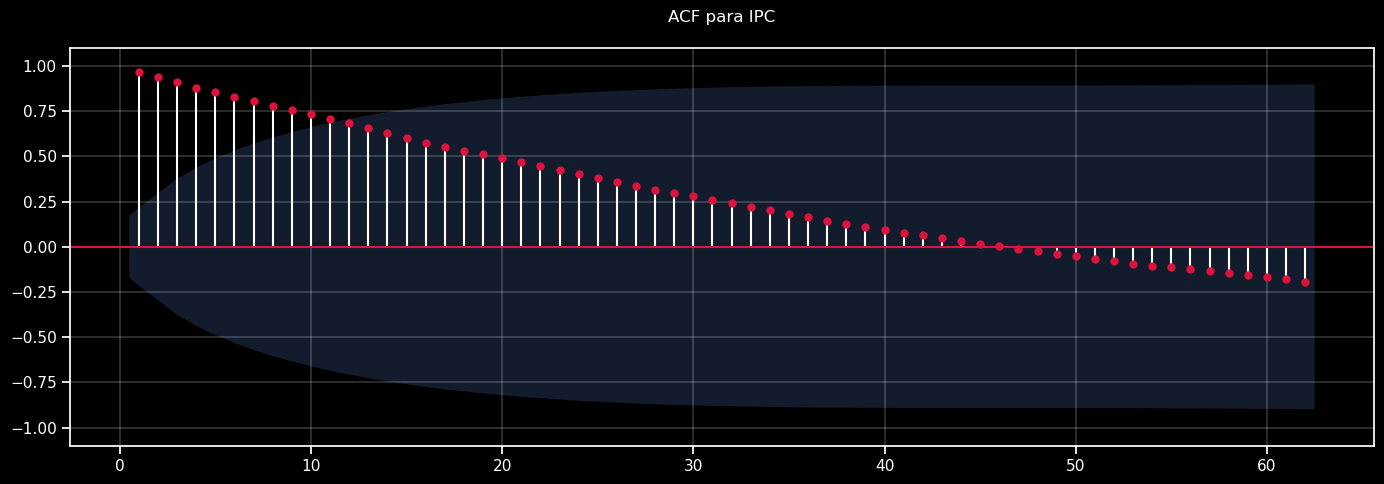

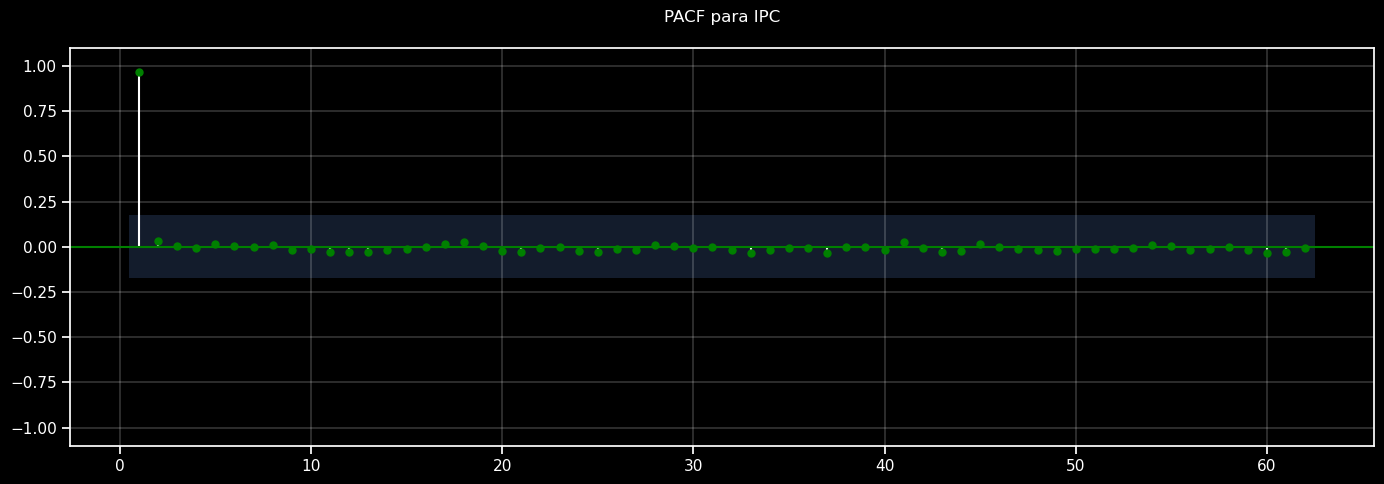

In [4]:
# Gráfico de función de autocorrelación y autocorrelación parcial
acf_y_pcf(data=data, lags=(len(data)//2) - 1)

In [5]:
# Variables Generales
# ==============================================================================
target = 'IPC'

# Punto de corte
fin_entrenamiento = data.iloc[int(data.shape[0]*0.8):].index[0]

## **Baseline - Simulación del Random Walk**

A la hora de generar un modelo predictivo es conveniente identificar un modelo de línea base, o baseline, sobre el que ir comparando cada una de las iteraciones o modelos propuestos. En el caso de las finanzas, acorde a la teoría del paseo aleatorio o Random Walk, los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ es el valor $t_n$ más un cambio impredecible.

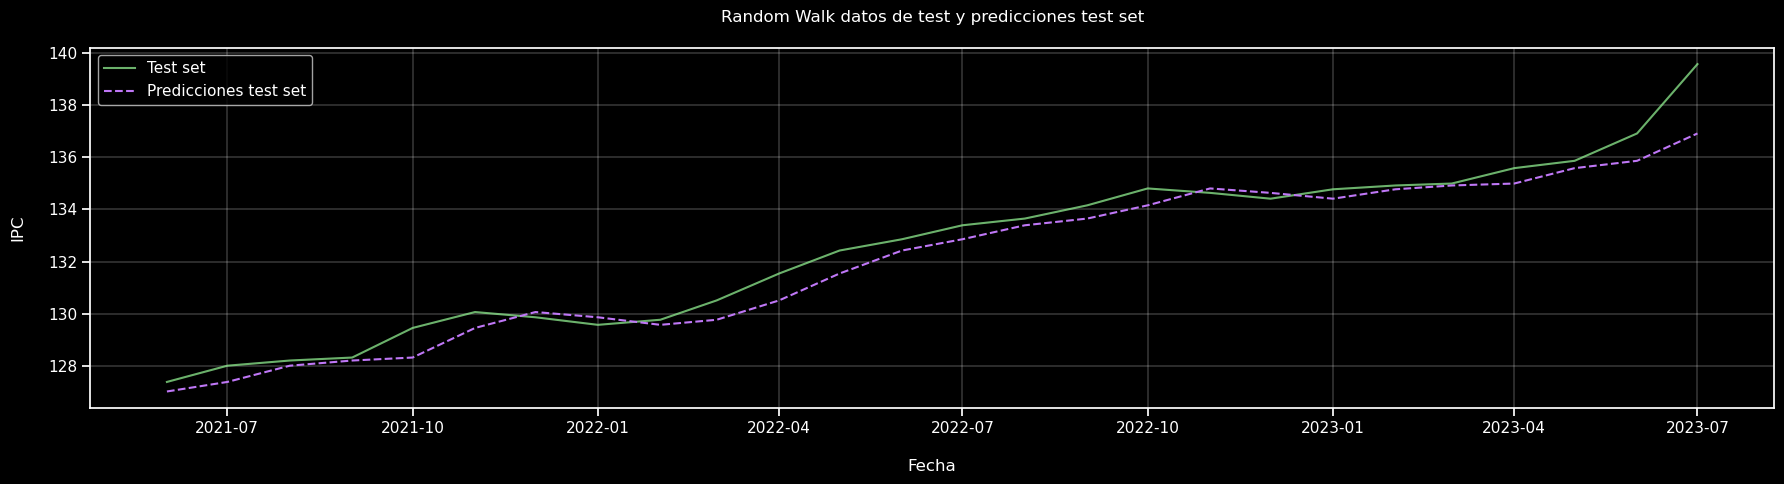

In [6]:
# Simulación Random Walk
# ==============================================================================
np.random.seed(42)
serie = data[target]

# Calculando las diferencias de la serie
diferencias = serie.diff().fillna(0)

# Introduciendo ruido a las diferencias
ruido = np.random.normal(loc=0.5, scale=0.001, size=len(diferencias))

# Construyendo el random walk a partir de la serie
random_walk = pd.DataFrame(serie.iloc[0] + diferencias.cumsum() * ruido, columns=[target])
random_walk['preds'] = random_walk[target].shift()

y_true = random_walk.loc[fin_entrenamiento:, target]
y_pred = random_walk.loc[fin_entrenamiento:, 'preds']

# Graficando
plt.figure(figsize=(18, 5))
plt.plot(y_true.index, y_true, label='Test set', color='lightgreen', alpha=0.75, linestyle='-')
plt.plot(y_pred.index, y_pred, label='Predicciones test set', color='xkcd:light purple', linestyle='dashed')
plt.title('Random Walk datos de test y predicciones test set\n')
plt.xlabel(f'\n{y_true.index.name}')
plt.ylabel(f'{y_true.name}\n')
plt.legend()
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [7]:
# Dataframe de rendimiento del modelo de línea base
rendimiento = pd.DataFrame({
    'Modelo': 'Random Walk',
    'MAE': mean_absolute_error(y_true, y_pred),
    'MAPE': loss_function(y_true, y_pred)[0],
    'RMSE': loss_function(y_true, y_pred)[1],
    'RMSPE': loss_function(y_true, y_pred)[2],
    'R²': loss_function(y_true, y_pred)[3],
    'exog': [False]
})

rendimiento

,Modelo,MAE,MAPE,RMSE,RMSPE,R²,exog
0,Random Walk,0.5512,0.0041,0.7560,0.0056,0.9410,False


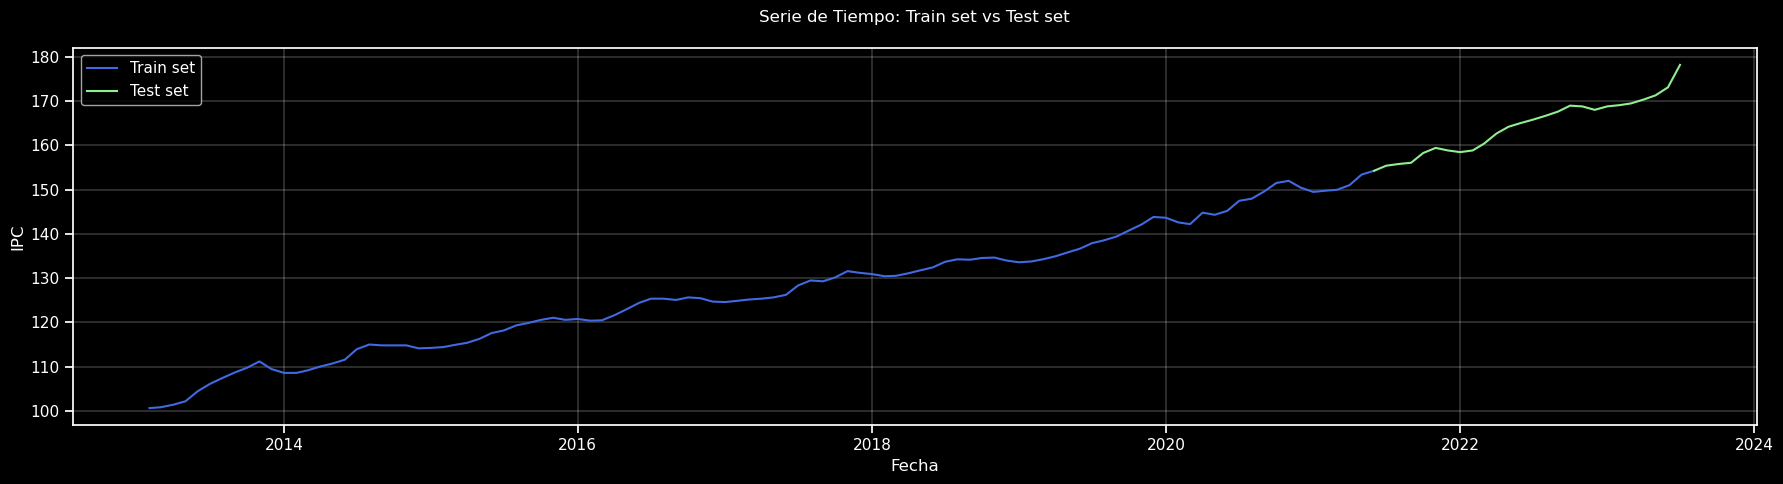

In [8]:
# Graficamos los datos de entrenamiento y prueba
plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                         test_data=data.loc[fin_entrenamiento:, target])

In [9]:
# Modelado
# ==============================================================================
lags_linear = 30
lags_no_linear = 32
steps = 36
seed = 55
tmp_feats = ['month', 'week', 'day_of_week', 'day_of_month', 'year']

# Hiperparámetros de los regresores
param_grid_linear_models = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

param_grid_no_linear_models = {
    'n_estimators': list(range(500, 1001, 100)),
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

# Lista de regresores empaquetados con sus respectivos diccionarios de hiperparámetros y pipelines
regresores = [
    # Lineales
    (Ridge(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (Lasso(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (GeneralizedLinearRegressor(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    
    # No lineales
    (XGBRegressor(random_state=seed, tree_method='gpu_hist', n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models),
    (LGBMRegressor(random_state=seed, verbose=-1, n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models)
]

# Inicialización del diccionario de resultados
resultados = dict()

for model, param_grid, tmp, pipeline in regresores:
    # Ingeniería de variables
    # ==============================================================================
    data_transformada = pipeline(data=data, tmp=tmp, target=target, n_windows=10)
    variables_exogenas = [var for var in data_transformada.columns if var != target]
    
    # Forecaster
    # ==============================================================================
    if isinstance(model, (Ridge, Lasso, GeneralizedLinearRegressor)):
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_linear,
            transformer_y=StandardScaler()
        )
    
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_linear+1))    
        
    else:
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_no_linear,
            differentiation=1
        )
        
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_no_linear+1))
    
    # Búsqueda en grilla de hiperparámetros y lags
    # ==============================================================================
    resultados_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps, # Número de pasos hacia adelante optimizando el modelo durante la búsqueda de la mejor combinación de parámetros
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            return_best        = True,
                            n_jobs             = -1,
                            verbose            = False,
                            fixed_train_size   = False,
                            show_progress      = False
)
    
    # Backtesting datos de validación
    # ==============================================================================
    mae, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            steps              = steps, # La cantidad de pasos hacia adelante que el modelo va a predecir en cada iteración del backtest
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            n_jobs             = -1,
                            interval           = [5, 95],
                            verbose            = False, # True para ver detalles del backtesting
                            fixed_train_size   = False,
                            show_progress      = False                           
)   
    
    # Función de pérdida para medir el rendimiento de los modelos
    # ==============================================================================
    mape, rmse, rmspe, r2 = loss_function(
                        y_true = data_transformada.loc[fin_entrenamiento:, target][1:],
                        y_pred = predicciones['pred']
)
    
    # Almacenar las predicciones y las métricas al Dataframe de rendimientos
    # ==============================================================================
    nuevo_rendimiento = pd.DataFrame({
        'Modelo': [type(model).__name__],
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'R²': r2,
        'exog': [True]
    })
    
    # Actualizamos los rendimientos de los modelos
    rendimiento = pd.concat([rendimiento, nuevo_rendimiento], ignore_index=True)
    
    # Almacenar el nombre del modelo, las predicciones y el objeto del modelo en el diccionario
    resultados[type(model).__name__] = {
        'nombre': type(model).__name__,
        'predicciones': predicciones, # Contiene un diccionario con las predicciones y los intervalos de confianza
        'modelo_objeto': model,
        'forecaster': forecaster,
        'vars_exog': data_transformada
    }

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
  Parameters: {'alpha': 1}
  Backtesting metric: 0.7358160068698828

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 0.8355060065583894

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8 9] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 0.7563108238642371

Number of models compared: 3072.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_

In [10]:
# Rendimiento de los modelos
# ==============================================================================
# Ordenamos de acuerdo a las métricas de nuestro interés
df_rendimiento = rendimiento.sort_values(by=['RMSE', 'MAE', 'RMSPE', 'MAPE', 'R²']).set_index('Modelo')

# Ajustar nombres de columnas e índices
df_rendimiento.columns.name = None
df_rendimiento.index.name = None
df_rendimiento

,MAE,MAPE,RMSE,RMSPE,R²,exog
Random Walk,0.5512,0.0041,0.7560,0.0056,0.9410,False
Ridge,0.7358,0.0044,0.9830,0.0058,0.9727,True
LGBMRegressor,0.7537,0.0046,1.0446,0.0062,0.9692,True
GeneralizedLinearRegressor,0.7563,0.0046,1.0813,0.0064,0.9670,True
XGBRegressor,0.7434,0.0045,1.0828,0.0065,0.9669,True
Lasso,0.8355,0.0050,1.1345,0.0067,0.9636,True


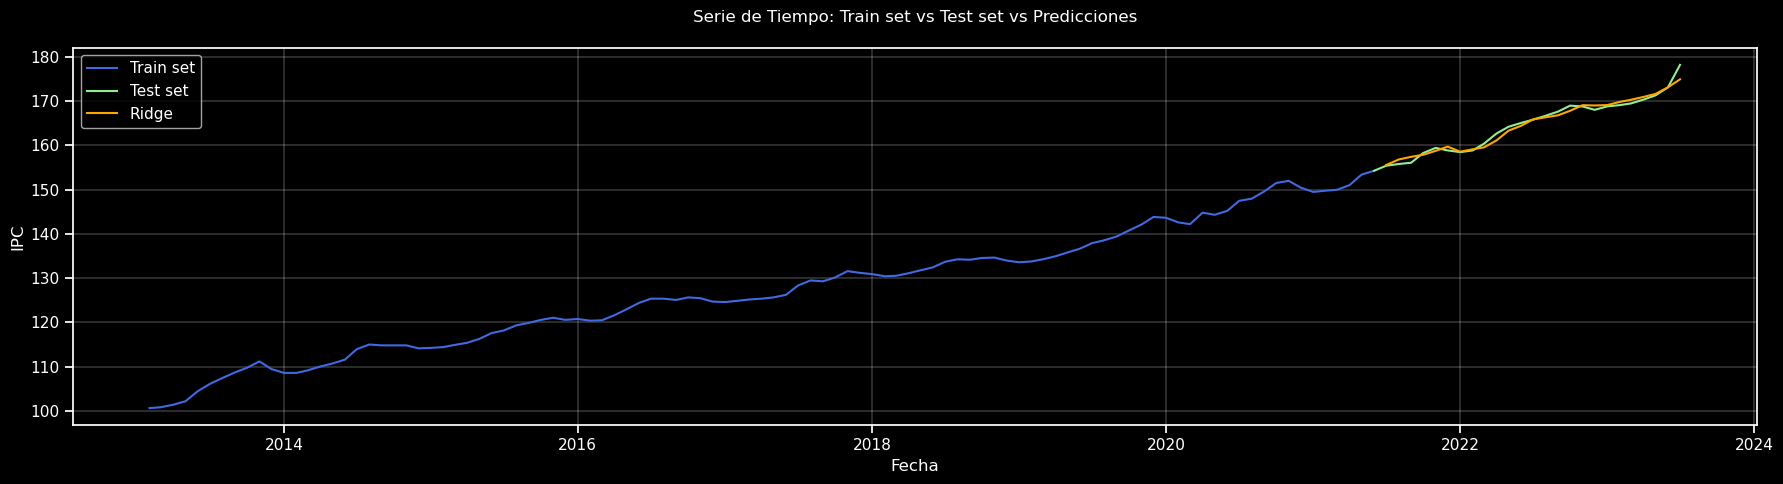

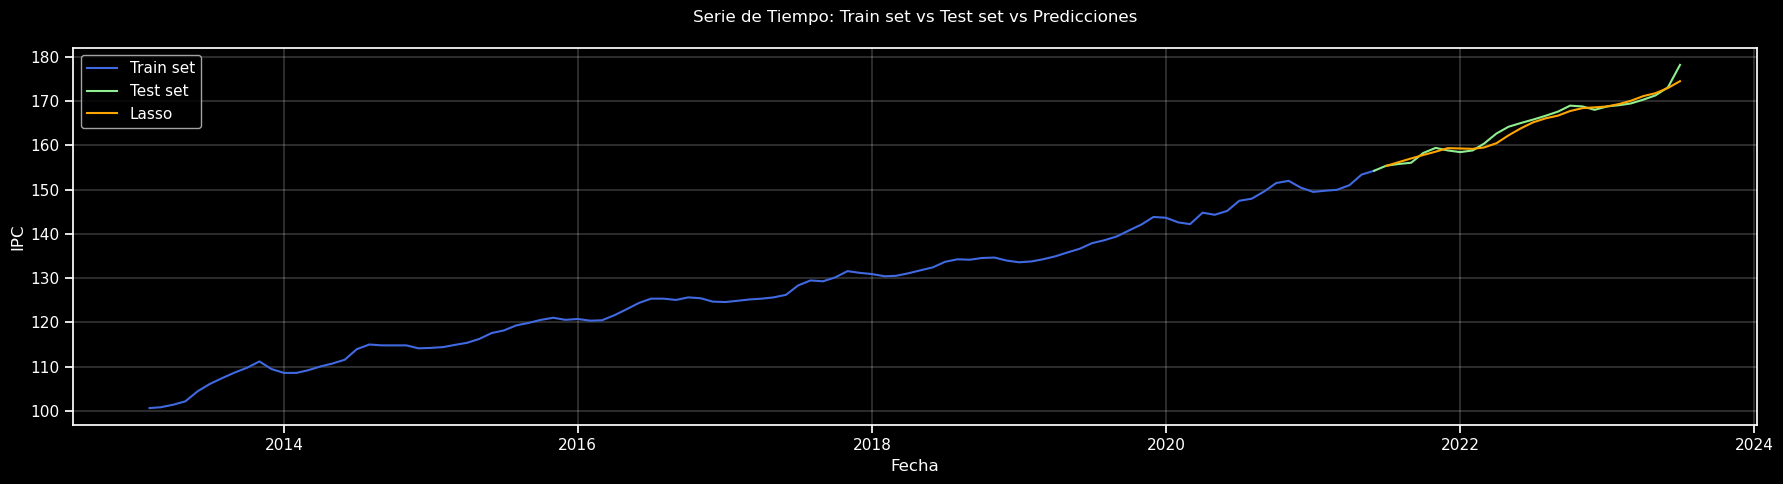

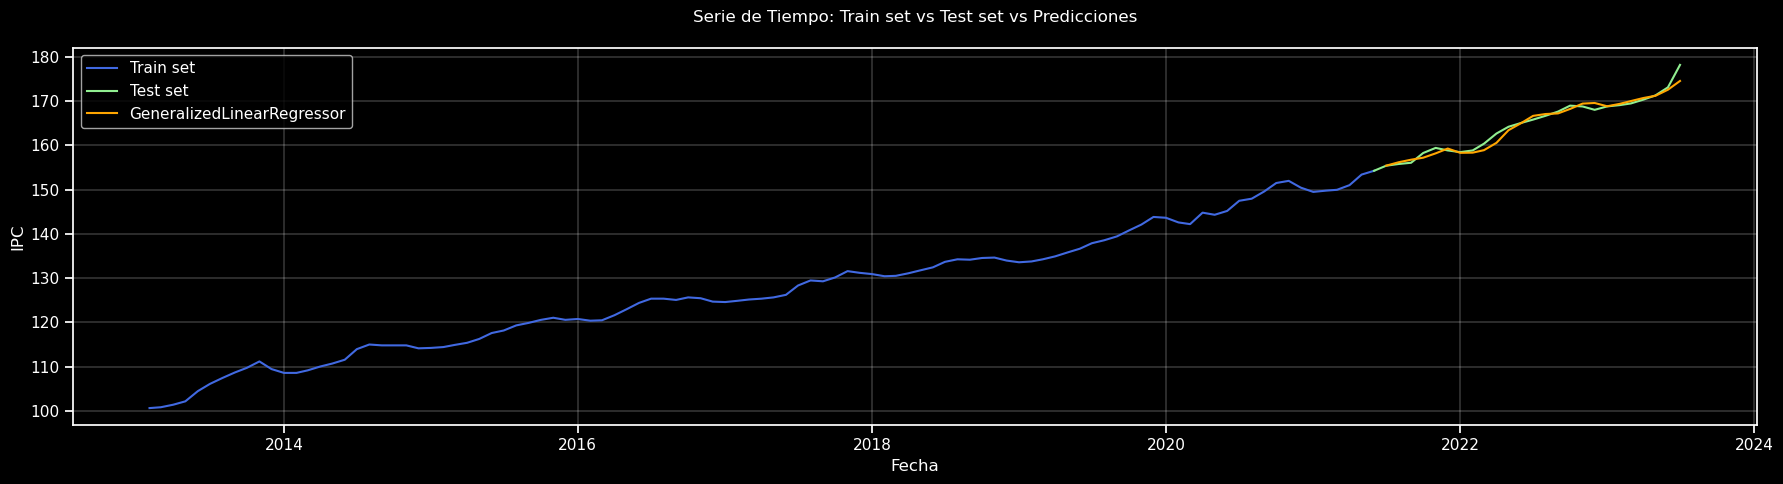

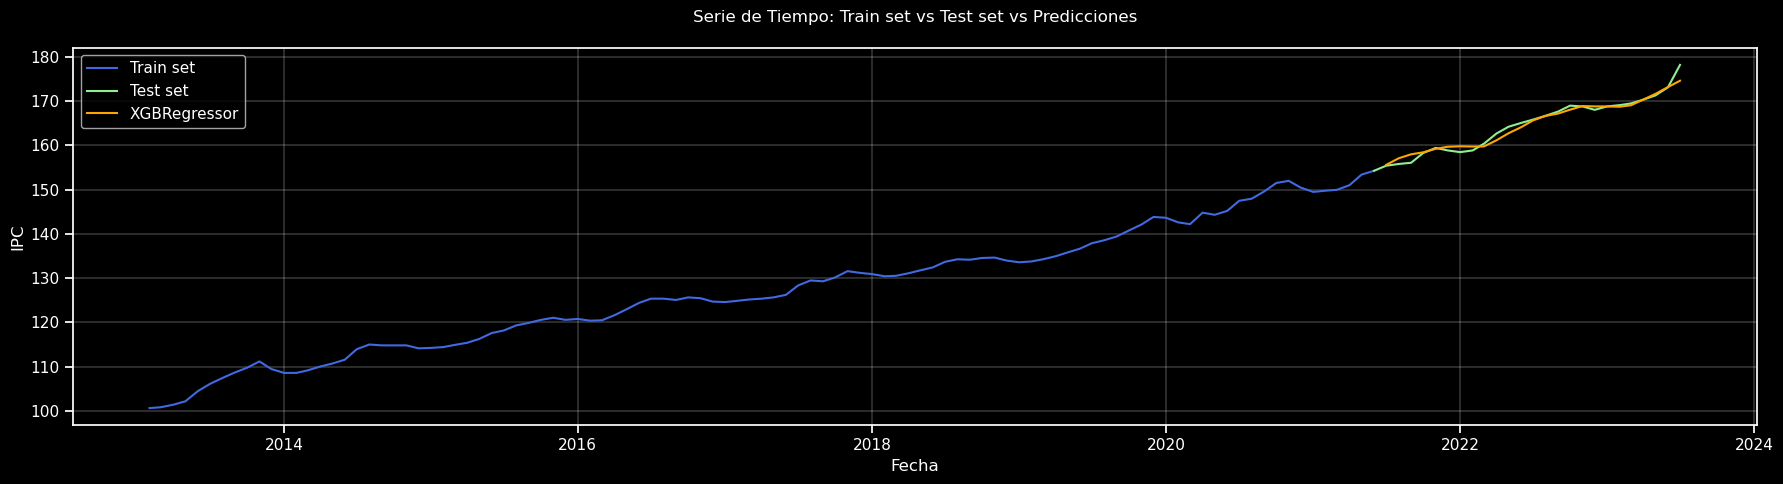

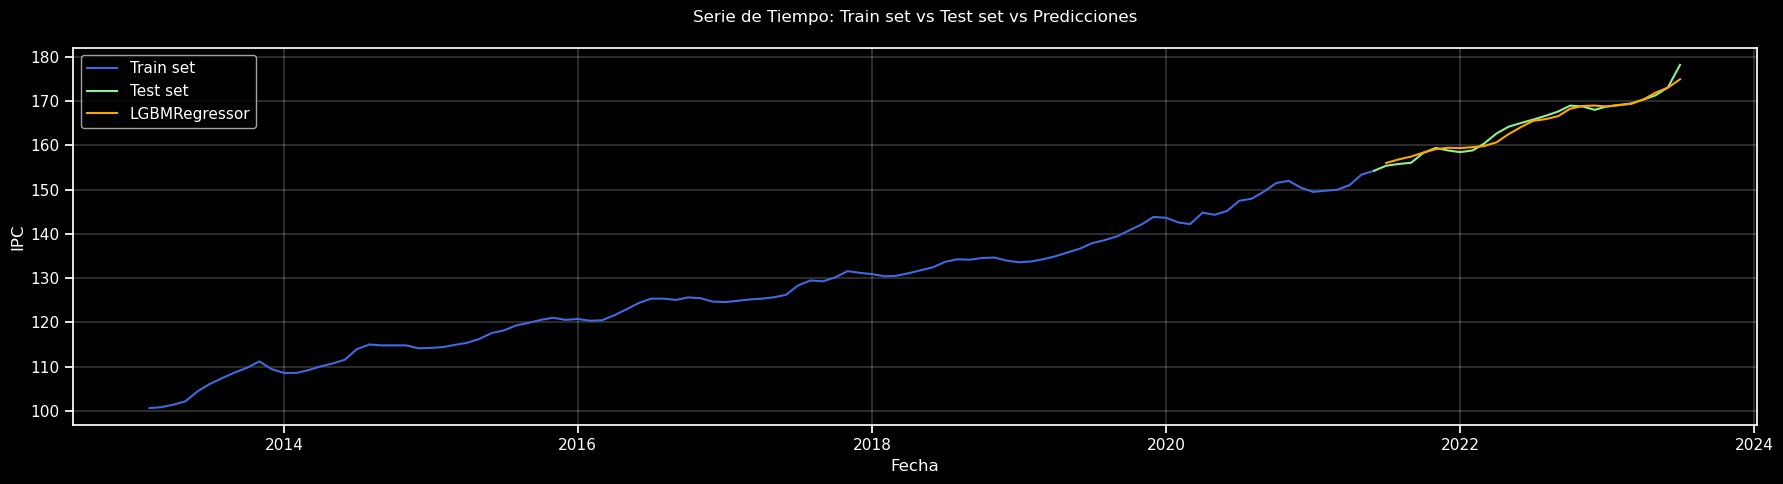

In [11]:
# Resultados
# ==============================================================================
for name, model_data in resultados.items():
    plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                             test_data=data.loc[fin_entrenamiento:, target],
                             modelo=model_data['modelo_objeto'],
                             preds_data=model_data['predicciones']['pred'])

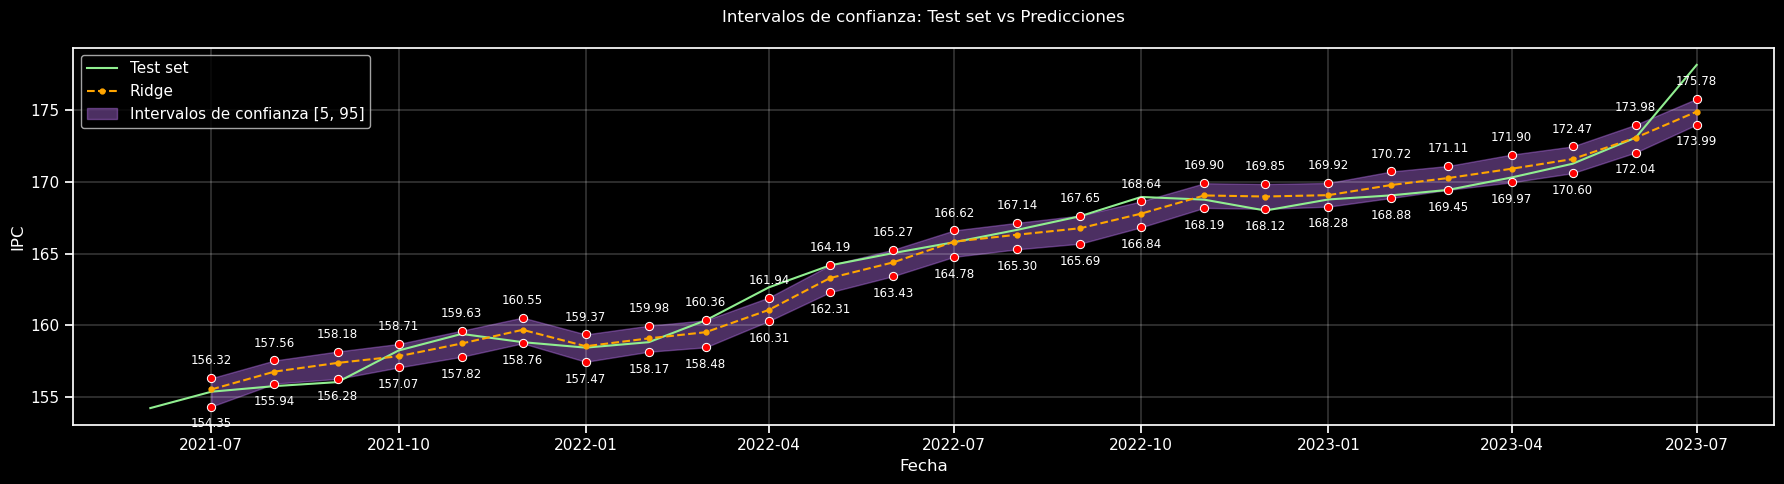

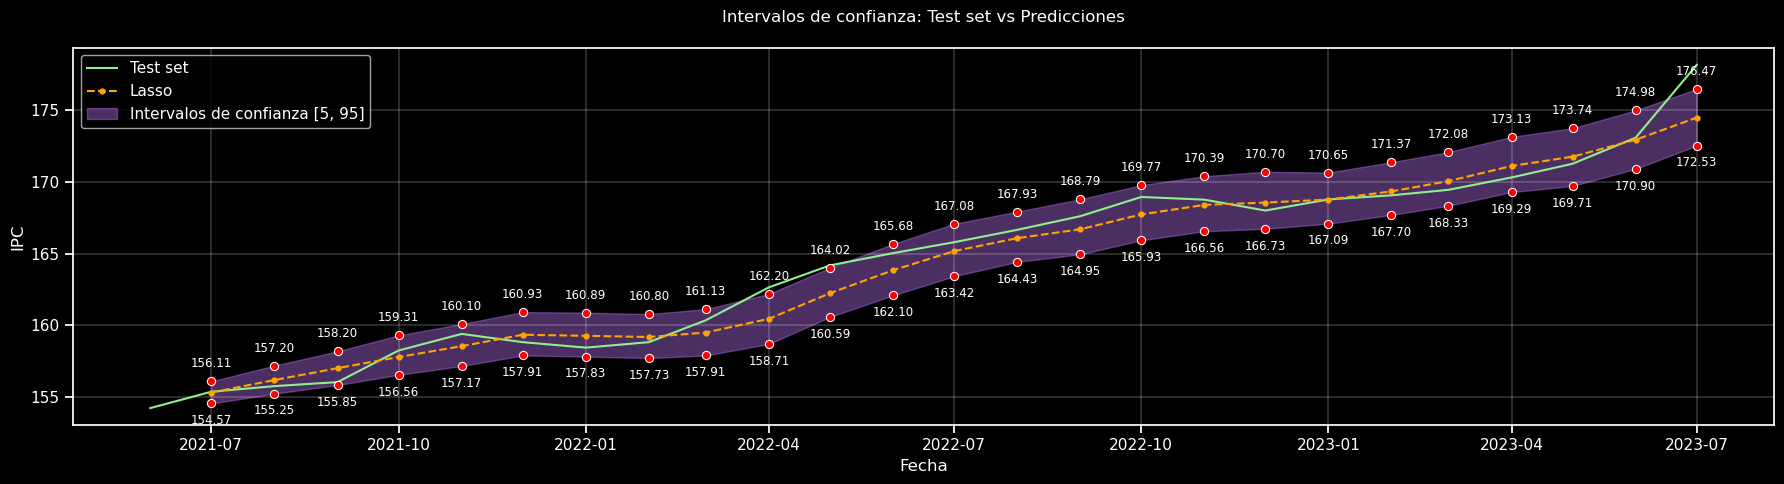

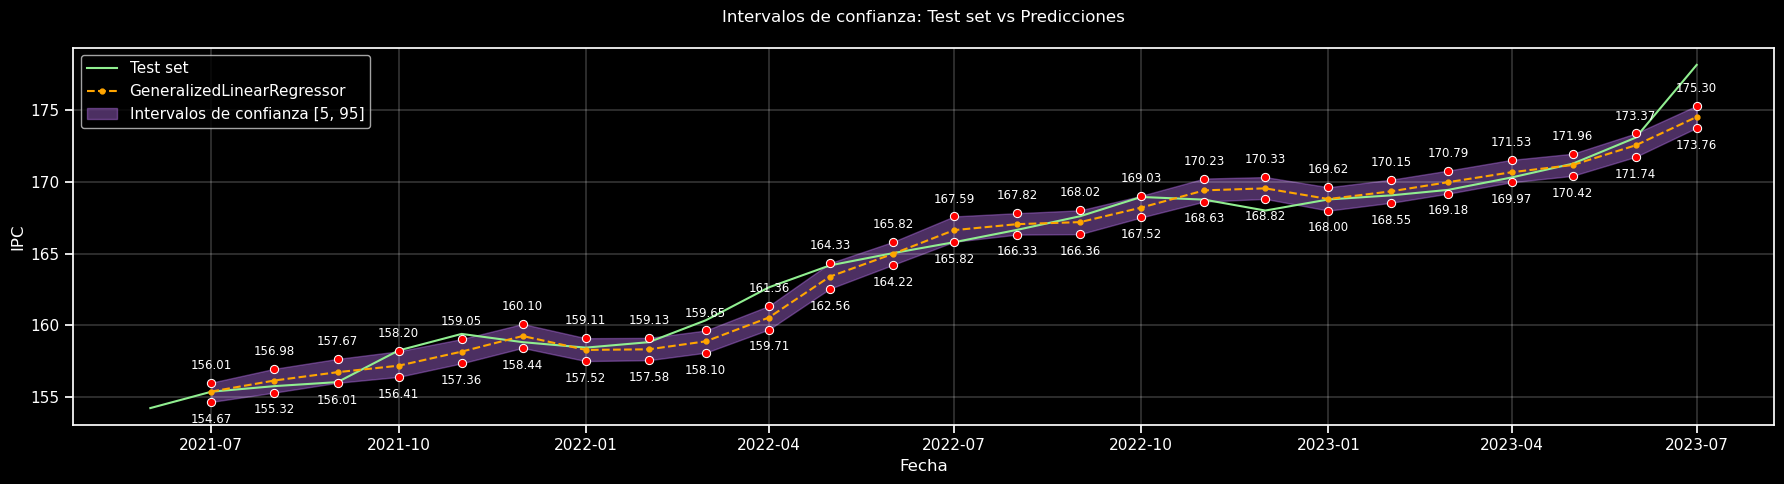

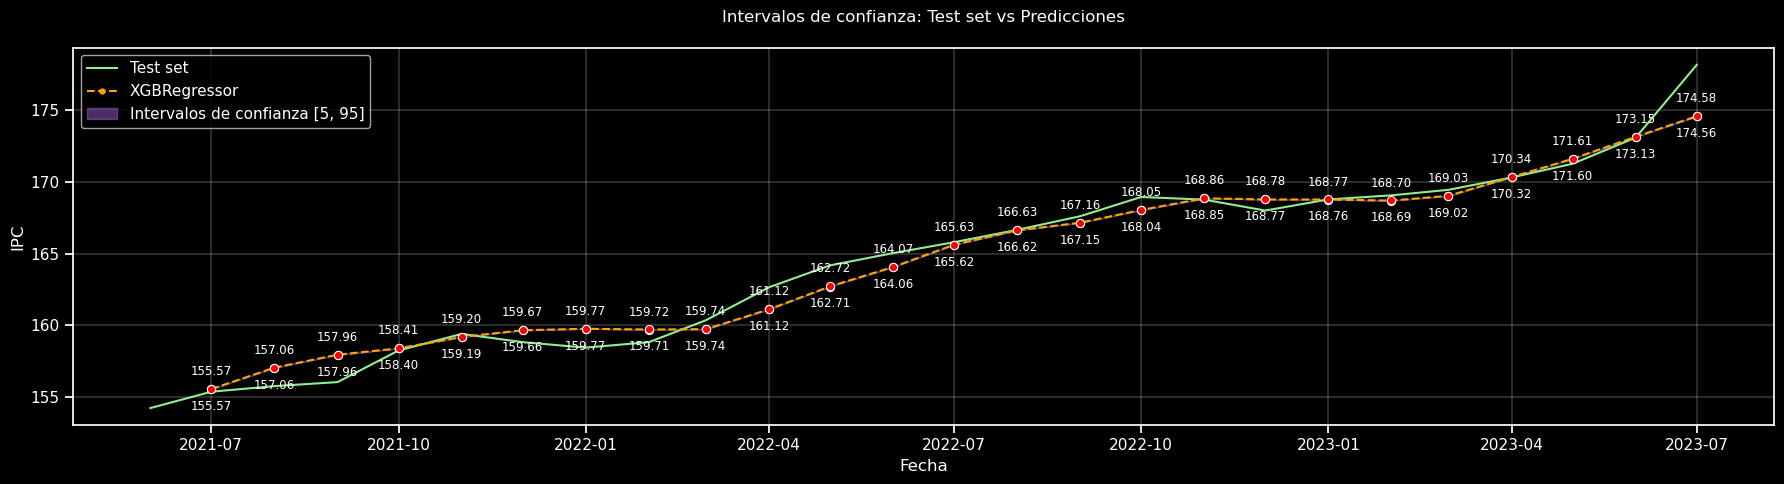

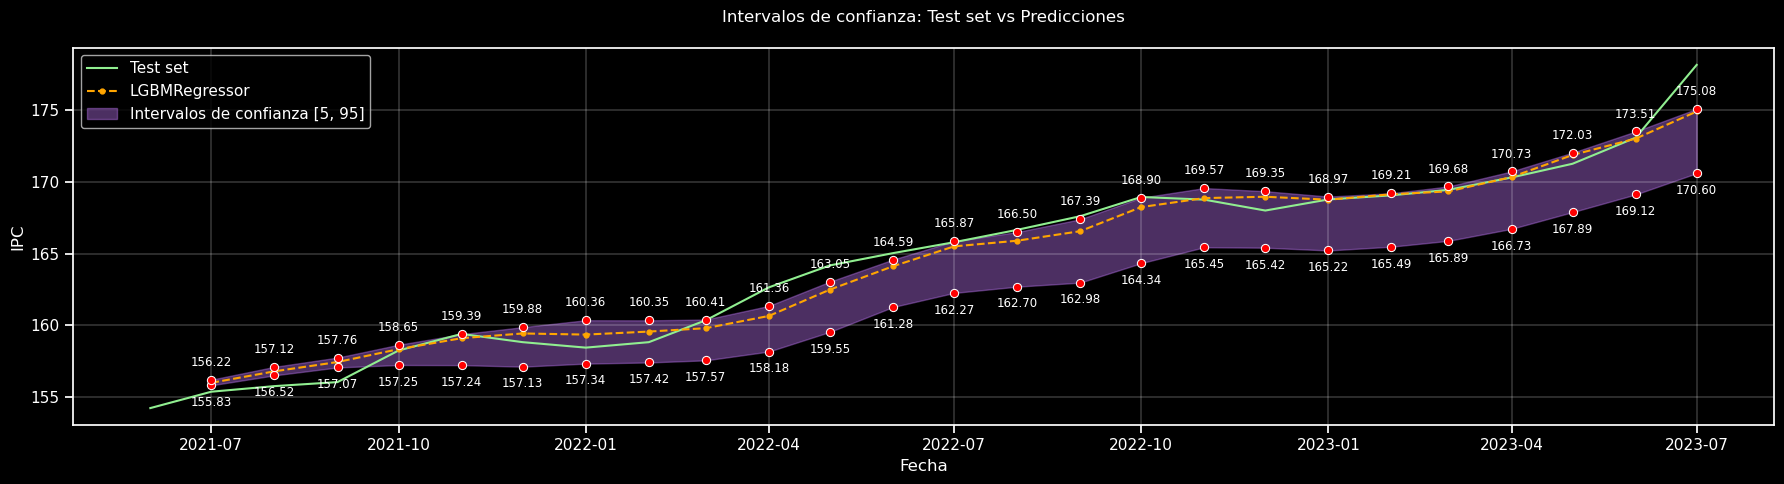

In [12]:
# Intervalos de confianza en el limite 5 y 95
# ==============================================================================
for name, model_data in resultados.items():
    plotting_confidence_intervals_preds(test_data=data.loc[fin_entrenamiento:, target],
                                        modelo=model_data['modelo_objeto'],
                                        preds_data=model_data['predicciones']['pred'],
                                        intervals_preds=model_data['predicciones'])

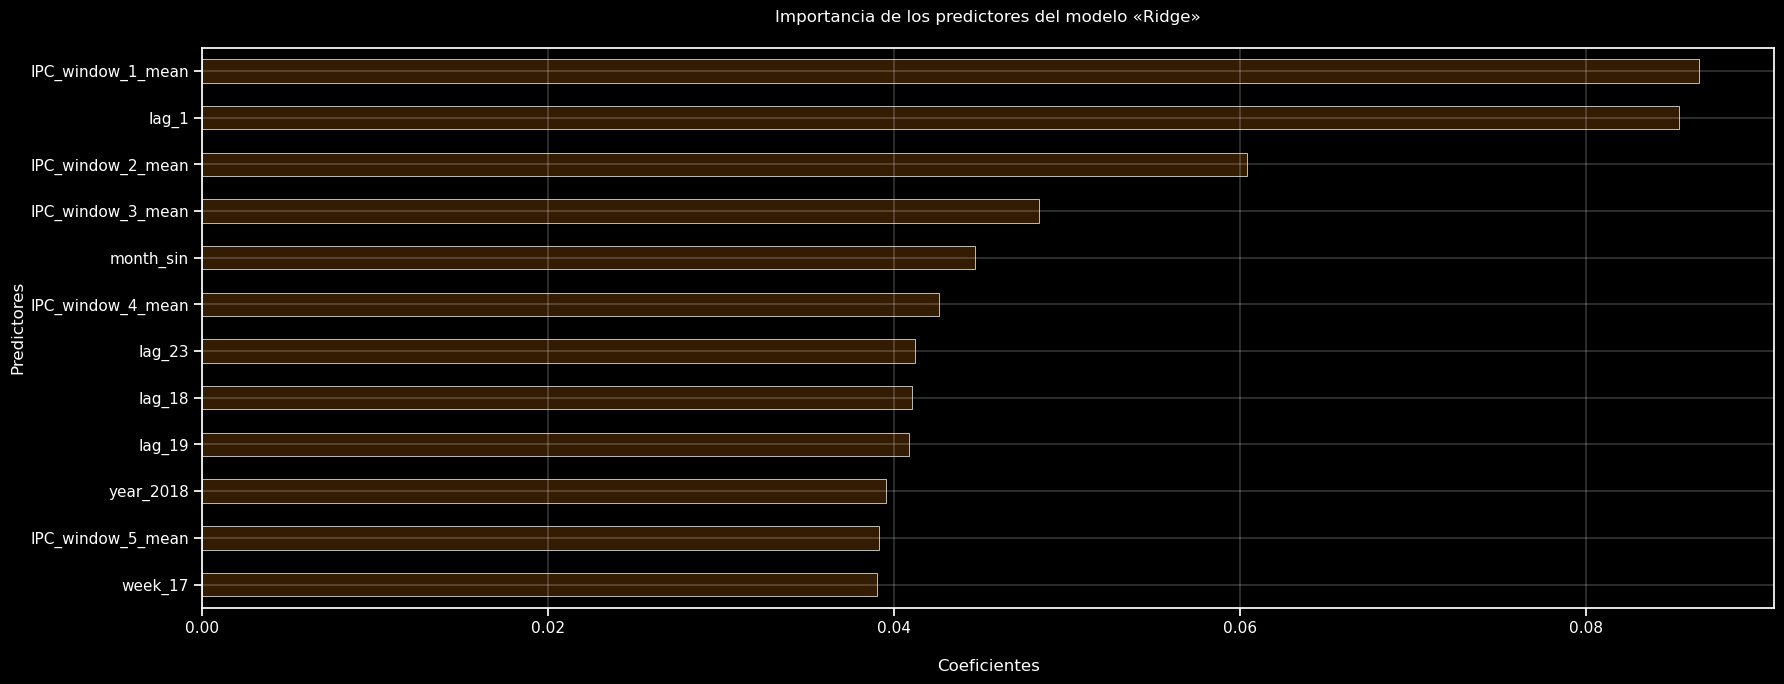

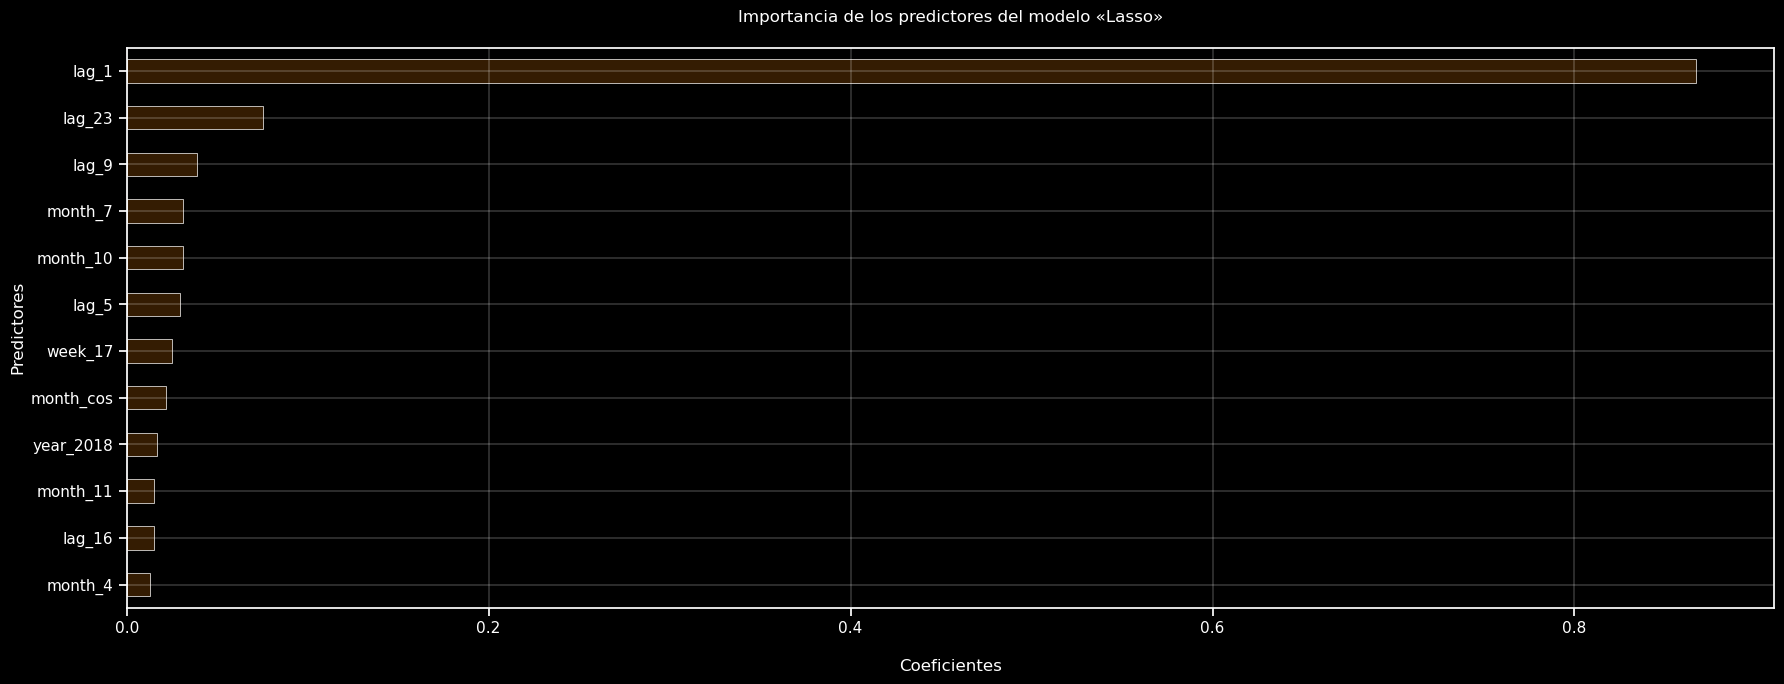

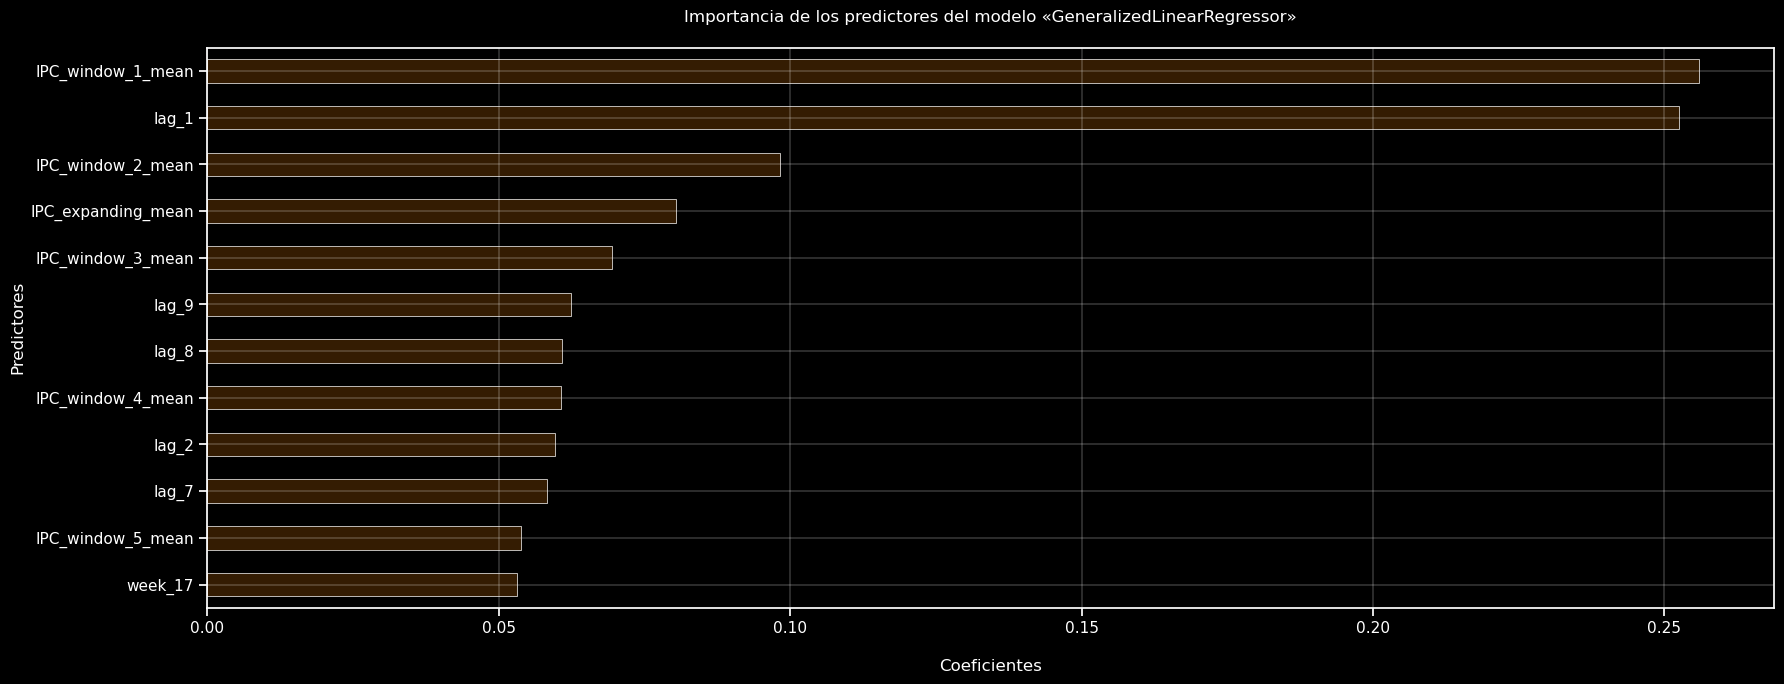

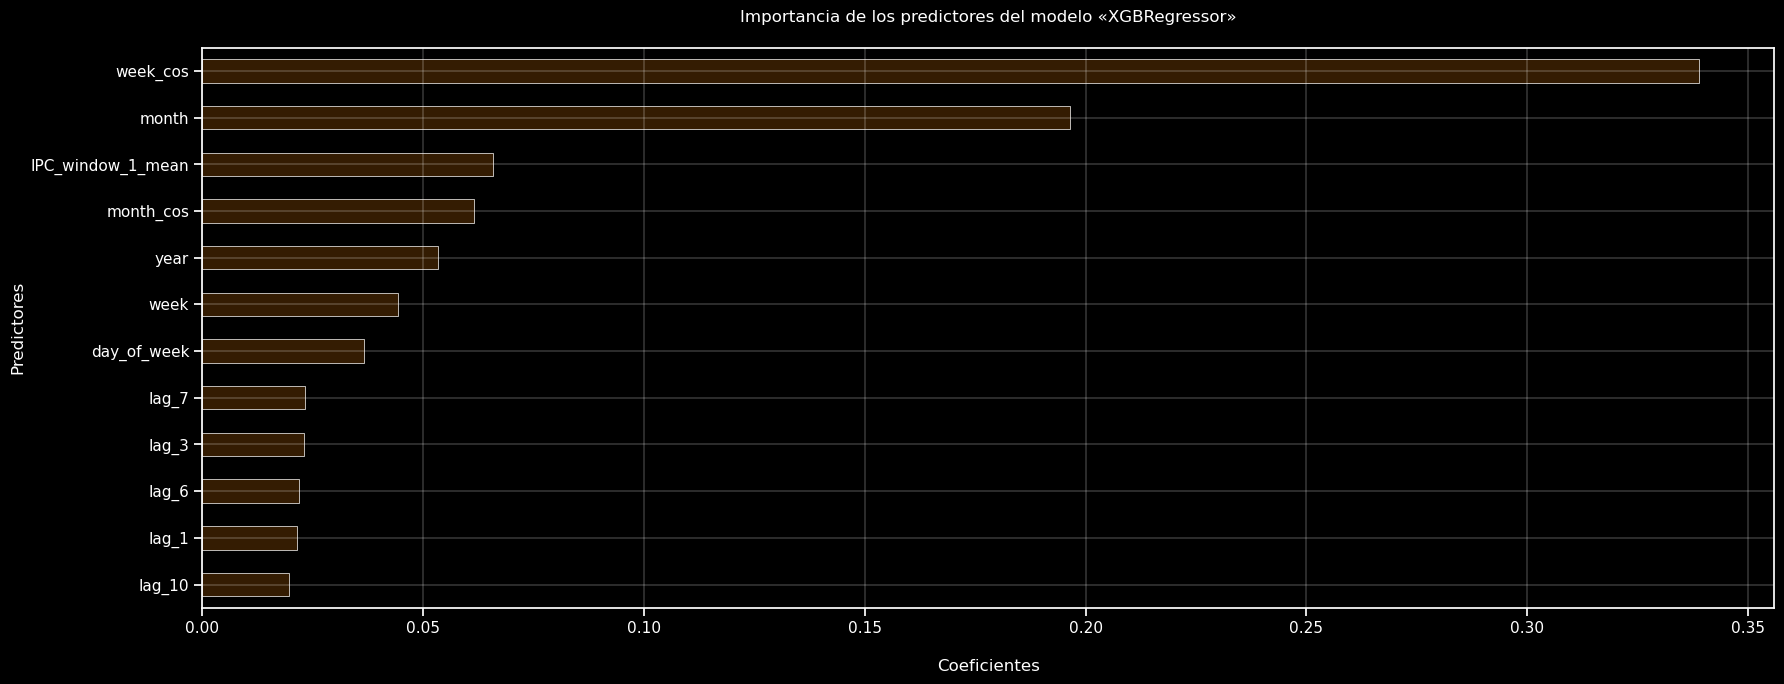

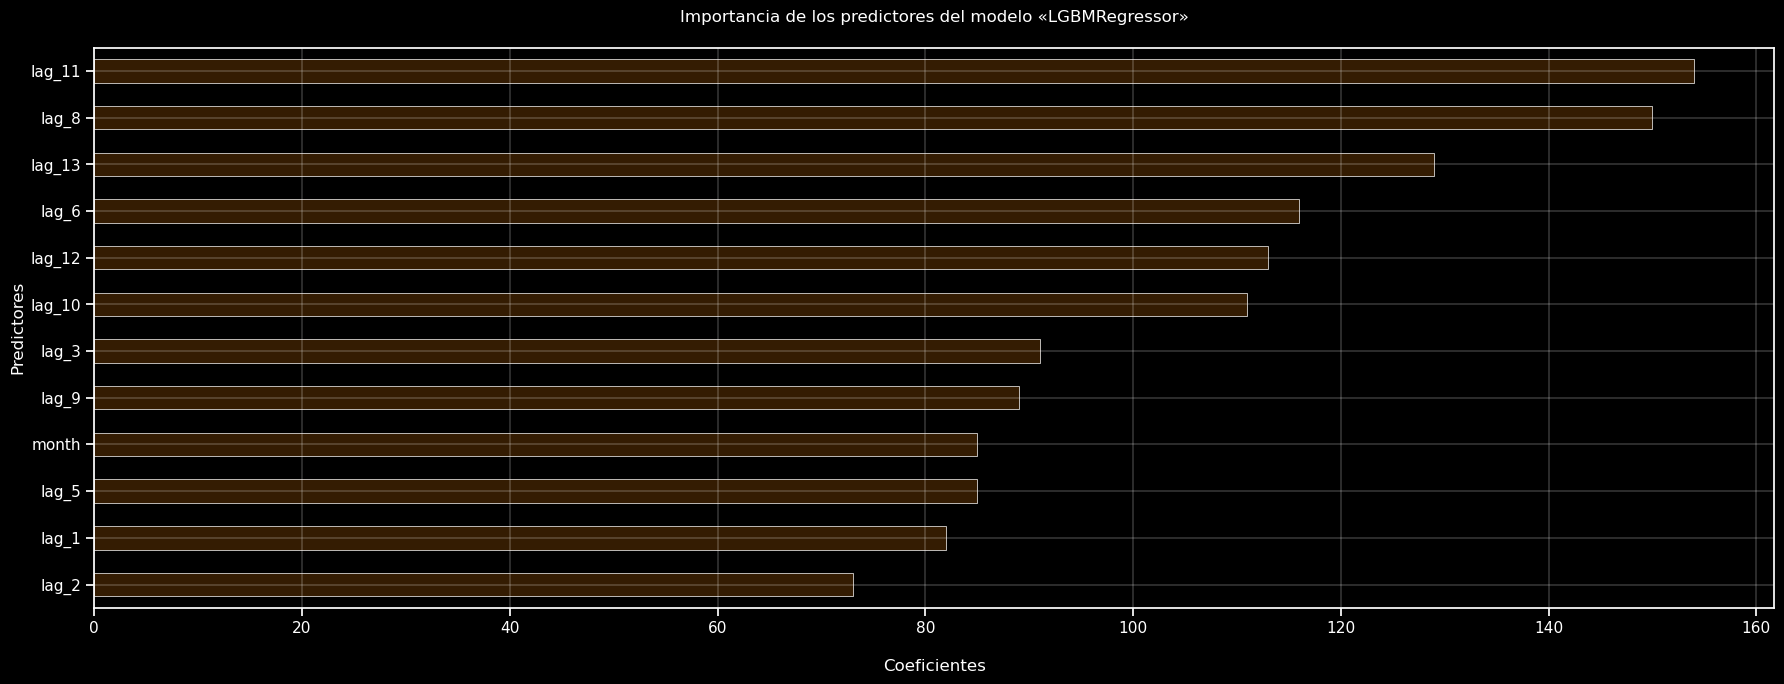

In [13]:
# Importancia de los predictores del modelo
# ==============================================================================
for model_name in resultados.keys():
    importances = resultados[model_name]['forecaster'].get_feature_importances()
    
    # Si no hay importancias o el DataFrame está vacío, imprime un mensaje y continua con el siguiente modelo
    if importances is None or importances.empty:
        continue
    
    # Si hay importancias, procedemos a graficar
    importances['importance'] = importances['importance'].abs()
    importances = importances.nlargest(12, 'importance').sort_values('importance')
    
    importances.set_index('feature', inplace=True)
    importances.plot.barh(
        figsize=(18, 7), 
        color='xkcd:dark brown', 
        width=0.5,
        edgecolor='white', 
        lw=0.5, 
        legend=False
    )

    # Agregar etiquetas y títulos
    plt.title(f'Importancia de los predictores del modelo «{model_name}»\n')
    plt.xlabel('\nCoeficientes')
    plt.ylabel('Predictores')
    plt.grid(color='white', linestyle='-', linewidth=0.25)
    plt.tight_layout()
    plt.show()


In [14]:
# Revisamos los datos de entrada y el target del mejor modelo
# ==============================================================================
best_model = resultados[df_rendimiento.index[1]]
data_transformada = best_model['vars_exog']

X_train, y_train = best_model['forecaster'].create_train_X_y(
                        y = data_transformada.loc[:fin_entrenamiento, target],
                        exog = data_transformada.loc[:fin_entrenamiento, data_transformada.columns])
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,IPC,IPC_window_1_mean,IPC_window_2_mean,IPC_window_3_mean,IPC_window_4_mean,IPC_window_5_mean,IPC_window_6_mean,IPC_window_7_mean,IPC_window_8_mean,IPC_window_9_mean,IPC_window_10_mean,IPC_expanding_mean,month_sin,month_cos,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_1,week_5,week_9,week_14,week_18,week_22,week_27,week_31,week_35,week_40,week_44,week_48,week_1,week_36,week_49,week_23,week_53,week_13,week_17,week_26,week_39,week_52,week_30,day_of_week_4,day_of_week_0,day_of_week_2,day_of_week_5,day_of_week_3,day_of_week_6,day_of_week_1,day_of_month_1,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,-0.7269,-0.6889,-0.7277,-0.7817,-0.8278,-0.9200,-0.9664,-1.0739,-1.1435,-1.1823,-1.2210,-1.2366,-1.2440,-1.1904,-1.1904,-1.1904,-1.1747,-1.2590,-1.4511,-1.5205,-1.5745,-1.6439,-1.6902,-1.6902,-1.6206,120.7843,-0.8844,-0.8602,-0.8532,-0.8529,-0.8540,-0.8610,-0.8665,-0.8765,-0.8865,-0.8944,-0.9267,0.5000,0.8660,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2016-02-01,-0.7114,-0.7269,-0.6889,-0.7277,-0.7817,-0.8278,-0.9200,-0.9664,-1.0739,-1.1435,-1.1823,-1.2210,-1.2366,-1.2440,-1.1904,-1.1904,-1.1904,-1.1747,-1.2590,-1.4511,-1.5205,-1.5745,-1.6439,-1.6902,-1.6902,120.3978,-0.8738,-0.8679,-0.8494,-0.8407,-0.8378,-0.8367,-0.8410,-0.8447,-0.8527,-0.8612,-0.8965,0.8660,0.5000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2016-03-01,-0.7425,-0.7114,-0.7269,-0.6889,-0.7277,-0.7817,-0.8278,-0.9200,-0.9664,-1.0739,-1.1435,-1.1823,-1.2210,-1.2366,-1.2440,-1.1904,-1.1904,-1.1904,-1.1747,-1.2590,-1.4511,-1.5205,-1.5745,-1.6439,-1.6902,120.4941,-0.8951,-0.8733,-0.8618,-0.8432,-0.8323,-0.8268,-0.8232,-0.8250,-0.8267,-0.8329,-0.8693,1.0000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
2016-04-01,-0.7347,-0.7425,-0.7114,-0.7269,-0.6889,-0.7277,-0.7817,-0.8278,-0.9200,-0.9664,-1.0739,-1.1435,-1.1823,-1.2210,-1.2366,-1.2440,-1.1904,-1.1904,-1.1904,-1.1747,-1.2590,-1.4511,-1.5205,-1.5745,-1.6439,121.6388,-0.8898,-0.8813,-0.8636,-0.8512,-0.8333,-0.8213,-0.8139,-0.8087,-0.8086,-0.8089,-0.8431,0.8660,-0.5000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2016-05-01,-0.6427,-0.7347,-0.7425,-0.7114,-0.7269,-0.6889,-0.7277,-0.7817,-0.8278,-0.9200,-0.9664,-1.0739,-1.1435,-1.1823,-1.2210,-1.2366,-1.2440,-1.1904,-1.1904,-1.1904,-1.1747,-1.2590,-1.4511,-1.5205,-1.5745,122.9768,-0.8266,-0.8470,-0.8477,-0.8365,-0.8268,-0.8114,-0.8000,-0.7925,-0.7869,-0.7861,-0.8147,0.5000,-0.8660,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,1.5957,1.6731,1.7966,1.7576,1.6036,1.4727,1.4348,1.2503,1.1807,1.2191,1.0110,1.0419,1.1262,1.1413,1.0030,0.8954,0.7878,0.7187,0.6644,0.5644,0.4956,0.4261,0.3721,0.3334,0.3183,149.7547,0.7086,0.7536,0.8091,0.8392,0.8430,0.8363,0.8328,0.8183,0.8057,0.8020,0.8024,0.8660,0.5000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2021-03-01,1.6185,1.5957,1.6731,1.7966,1.7576,1.6036,1.4727,1.4348,1.2503,1.1807,1.2191,1.0110,1.0419,1.1262,1

In [15]:
# Comparativa entre los datos reales de las predicciones tabularmente
pd.concat([data.loc[fin_entrenamiento:][1:], best_model['predicciones']['pred']], axis=1)

,IPC,pred
2021-07-01,155.3851,155.5422
2021-08-01,155.7736,156.7835
2021-09-01,156.0540,157.3903
2021-10-01,158.2543,157.8542
2021-11-01,159.4096,158.7431
2021-12-01,158.8357,159.6953
2022-01-01,158.4545,158.5506
2022-02-01,158.8348,159.0995
2022-03-01,160.3596,159.5301
2022-04-01,162.6528,161.0843


---